In [74]:
import glob
import warnings
warnings.filterwarnings('ignore')

from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol
from scipy.ndimage.morphology import distance_transform_edt
from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import catalyst
import albumentations as albu
from albumentations import torch as AT
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
os.environ['CUDA_VISIBLE_DEVICES']

from importlib import reload

# %load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [85]:
torch.cuda.is_available()

True

In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
train_images_dir = data_dir/"train"/"images"
test_images_dir = data_dir/"test"/"images"
train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

img_filepaths = (data_dir/"train"/"images").ls()
mask_filepaths = [mask_dir / f.name for f in img_filepaths]
img_ids =  [f.name.replace('.png', '') for f in mask_filepaths]
unique_img_ids = list(set(['_'.join(x.split('_')[:2]) for x in img_ids]))

np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [3]:
img_filepaths[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000024_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-matthew_00000005_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-florence_00000392_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000669_post_disaster.png')]

The masks can be hard 1/0s 

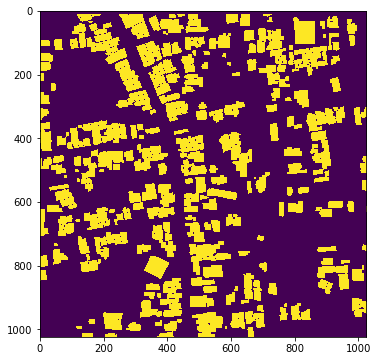

In [4]:
plt.figure(figsize=(6,6))
plt.imshow(np.array(PIL.Image.open(mask_dir/'palu-tsunami_00000024_pre_disaster.png'))/5 * 255)

Or a gaussian...

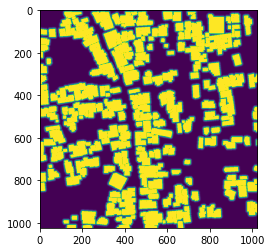

In [6]:
gt_array=np.array(PIL.Image.open(mask_dir/'palu-tsunami_00000024_pre_disaster.png'))
distance_array = distance_transform_edt(1-gt_array)
std = 5
distance_array =  np.exp(-0.5*(distance_array*distance_array)/(std*std))
distance_array *= 255
plt.imshow(distance_array)

In [7]:
train_images_crops.ls()[:10]

[PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-harvey_00000406_pre_disaster._8.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_midwest-flooding_00000417_post_disaster._4.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-michael_00000243_post_disaster._8.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_mexico-earthquake_00000034_pre_disaster._6.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_palu-tsunami_00000005_post_disaster._5.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-michael_00000454_pre_disaster._7.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_midwest-flooding_00000239_post_disaster._1.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_palu-tsunami_00000005_post_disaster._7.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_midwest-flooding_00000033_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/train

In [81]:
def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1,  2, figsize=(12,8))

        ax[0].imshow(image)
        ax[1].imshow(255 * mask/mask.max())
    else:
        f, ax = plt.subplots(2, 2, figsize=(12,12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[0, 1].imshow(255 * original_mask/original_mask.max())
        ax[0, 1].set_title('Original mask', fontsize=fontsize)
                
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].imshow(255 * mask/mask.max())
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        
def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')           
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)

# def get_preprocessing(preprocessing_fn):
#     """Construct preprocessing transform
    
#     Args:
#         preprocessing_fn (callbale): data normalization function 
#             (can be specific for each pretrained neural network)
#     Return:
#         transform: albumentations.Compose
    
#     """
    
#     _transform = [
#         preprocessing_fn,
#         albu.Lambda(image=to_tensor, mask=to_tensor),
#     ]
#     return albu.Compose(_transform)
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


In [54]:
mask.shape

(1024, 1024)

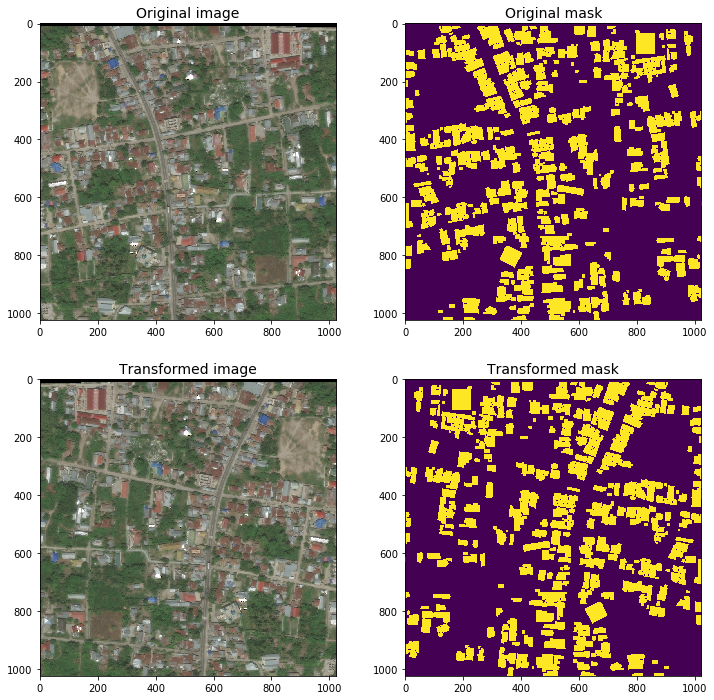

In [53]:
image = np.array(PIL.Image.open(train_images_dir/'palu-tsunami_00000024_pre_disaster.png'))
mask=np.array(PIL.Image.open(mask_dir/'palu-tsunami_00000024_pre_disaster.png'))
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

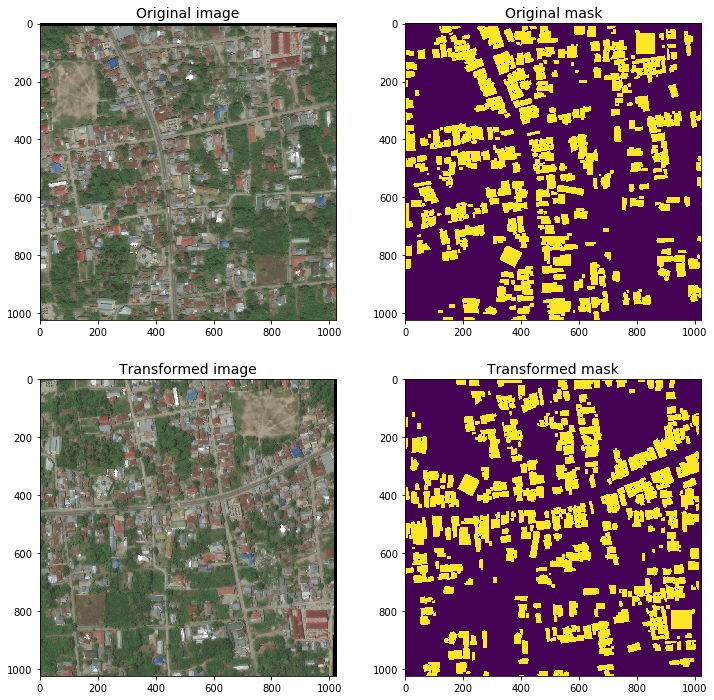

In [10]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

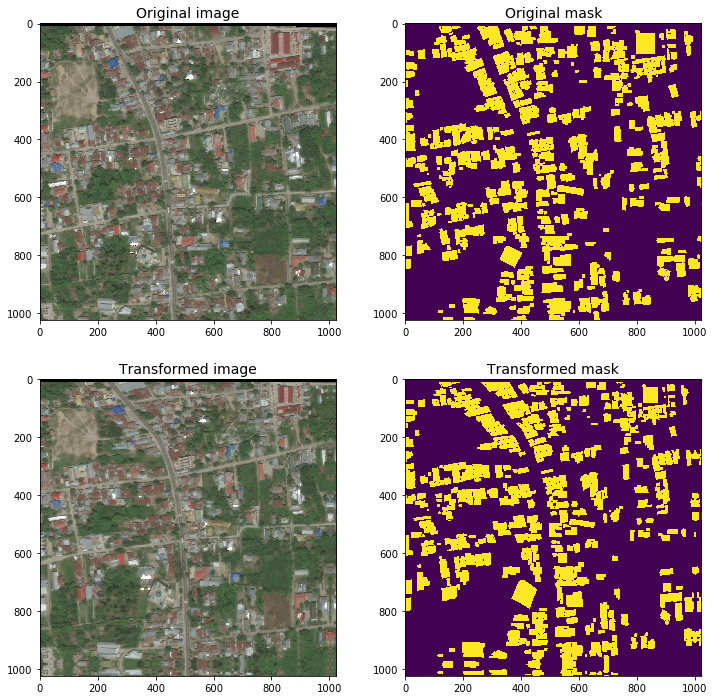

In [11]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

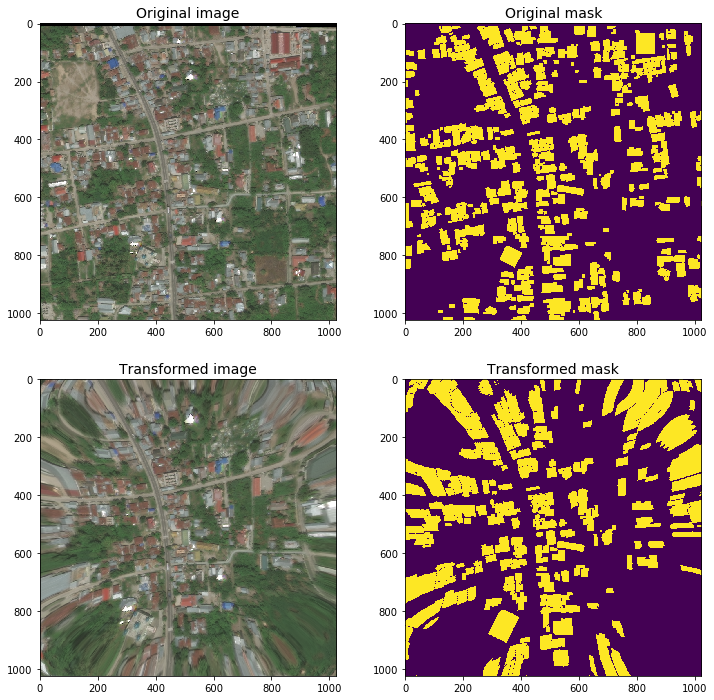

In [12]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=4, shift_limit=0.5))

In [43]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(256,256)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256,256)
    ]
    return albu.Compose(test_transform)

In [68]:
class BuildingsDataset(Dataset):
    def __init__(self,data_folder:Path = None, mask_folder:Path = None,
                 img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.data_folder = data_folder
        self.mask_folder = mask_folder
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask_name = image_name.replace('rgb', 'mask')
        
        image_path = Path(self.data_folder)/image_name
        img = np.array(PIL.Image.open(image_path))
        mask = np.array(PIL.Image.open(Path(self.mask_folder)/mask_name))
        
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            img = self.preprocessing(img)
        mask = to_tensor(mask[..., None])
        img = to_tensor(img)
            
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [80]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [66]:
mask[...,None].shape

(1024, 1024, 1)

In [18]:
train_images_dir.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000024_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-matthew_00000005_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-florence_00000392_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000669_post_disaster.png')]

In [7]:
train_ids[:5]

['hurricane-matthew_00000287',
 'hurricane-matthew_00000156',
 'hurricane-michael_00000144',
 'hurricane-harvey_00000245',
 'hurricane-florence_00000285']

In [60]:
train_crop_ids = [x.name for x in train_images_crops.ls() if '_'.join(x.name.split('_')[1:3]) in train_ids]
valid_crop_ids = [x.name for x in train_images_crops.ls() if '_'.join(x.name.split('_')[1:3]) in valid_ids]

In [61]:
['_'.join(x.name.split('_')[1:2]) for x in train_images_crops.ls()][:5]

['hurricane-harvey',
 'midwest-flooding',
 'hurricane-michael',
 'mexico-earthquake',
 'palu-tsunami']

In [78]:
bs=16
num_workers=0 # 0 means data loaded in main process
train_dataset = BuildingsDataset(data_folder=train_images_crops,
                                 mask_folder=train_mask_crops,img_ids=train_crop_ids,
                                 transforms=get_training_augmentation(), 
                                 preprocessing=preprocessing_fn)

valid_dataset = BuildingsDataset(data_folder=train_images_crops,
                                 mask_folder=train_mask_crops,img_ids=valid_crop_ids,
                                 transforms=get_validation_augmentation(), 
                                 preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}


In [72]:

# test_img, test_labels = next(iter(train_loader))

test_img[0].shape, test_labels[0].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

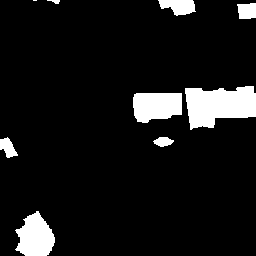

In [77]:
im = transforms.ToPILImage()(test_labels[0])
display(im)

In [26]:
num_epochs = 19
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.AdamW([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

In [82]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)








0/19 * Epoch (train):   0% 0/1578 [00:00<?, ?it/s]






0/19 * Epoch (train):   0% 0/1578 [00:00<?, ?it/s, _timers/_fps=34.363, dice=0.146, loss=2.025]






0/19 * Epoch (train):   0% 1/1578 [00:00<13:41,  1.92it/s, _timers/_fps=34.363, dice=0.146, loss=2.025]






0/19 * Epoch (train):   0% 1/1578 [00:00<13:41,  1.92it/s, _timers/_fps=38.110, dice=0.132, loss=2.018]






0/19 * Epoch (train):   0% 2/1578 [00:00<13:14,  1.98it/s, _timers/_fps=38.110, dice=0.132, loss=2.018]






0/19 * Epoch (train):   0% 2/1578 [00:01<13:14,  1.98it/s, _timers/_fps=35.413, dice=0.154, loss=2.139]






0/19 * Epoch (train):   0% 3/1578 [00:01<13:13,  1.98it/s, _timers/_fps=35.413, dice=0.154, loss=2.139]






0/19 * Epoch (train):   0% 3/1578 [00:01<13:13,  1.98it/s, _timers/_fps=40.489, dice=0.101, loss=2.007]






0/19 * Epoch (train):   0% 4/1578 [00:01<12:45,  2.06it/s, _timers/_fps=40.489, dice=0.101, loss=2.007]






0/19 * Epoch (train):   0% 4/1578 [00:02<12:45,  2.06it/s, _time

0/19 * Epoch (train):   2% 31/1578 [00:14<12:21,  2.09it/s, _timers/_fps=33.259, dice=0.080, loss=2.055]






0/19 * Epoch (train):   2% 31/1578 [00:15<12:21,  2.09it/s, _timers/_fps=30.460, dice=0.093, loss=2.013]






0/19 * Epoch (train):   2% 32/1578 [00:15<13:03,  1.97it/s, _timers/_fps=30.460, dice=0.093, loss=2.013]






0/19 * Epoch (train):   2% 32/1578 [00:15<13:03,  1.97it/s, _timers/_fps=38.037, dice=0.178, loss=2.069]






0/19 * Epoch (train):   2% 33/1578 [00:15<12:43,  2.02it/s, _timers/_fps=38.037, dice=0.178, loss=2.069]






0/19 * Epoch (train):   2% 33/1578 [00:16<12:43,  2.02it/s, _timers/_fps=35.190, dice=0.107, loss=2.048]






0/19 * Epoch (train):   2% 34/1578 [00:16<12:45,  2.02it/s, _timers/_fps=35.190, dice=0.107, loss=2.048]






0/19 * Epoch (train):   2% 34/1578 [00:17<12:45,  2.02it/s, _timers/_fps=33.014, dice=0.073, loss=1.973]






0/19 * Epoch (train):   2% 35/1578 [00:17<13:01,  1.98it/s, _timers/_fps=33.014, dice=0.073, loss=1.973]






0

0/19 * Epoch (train):   4% 62/1578 [00:29<11:48,  2.14it/s, _timers/_fps=36.412, dice=0.120, loss=2.036]






0/19 * Epoch (train):   4% 62/1578 [00:30<11:48,  2.14it/s, _timers/_fps=40.874, dice=0.149, loss=2.018]






0/19 * Epoch (train):   4% 63/1578 [00:30<11:35,  2.18it/s, _timers/_fps=40.874, dice=0.149, loss=2.018]






0/19 * Epoch (train):   4% 63/1578 [00:30<11:35,  2.18it/s, _timers/_fps=44.820, dice=0.150, loss=2.093]






0/19 * Epoch (train):   4% 64/1578 [00:30<11:09,  2.26it/s, _timers/_fps=44.820, dice=0.150, loss=2.093]






0/19 * Epoch (train):   4% 64/1578 [00:31<11:09,  2.26it/s, _timers/_fps=20.499, dice=0.058, loss=1.960]






0/19 * Epoch (train):   4% 65/1578 [00:31<14:04,  1.79it/s, _timers/_fps=20.499, dice=0.058, loss=1.960]






0/19 * Epoch (train):   4% 65/1578 [00:31<14:04,  1.79it/s, _timers/_fps=37.898, dice=0.105, loss=2.026]






0/19 * Epoch (train):   4% 66/1578 [00:31<13:22,  1.88it/s, _timers/_fps=37.898, dice=0.105, loss=2.026]






0

IndexError: tuple index out of range

In [36]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7f004fdce0d0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [86]:
catalyst.__version__

'19.08.6'